In [1]:
# Imports
import pandas as pd
import seaborn as sns
import numpy as np
import os
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
import re
from nltk.tokenize import RegexpTokenizer

from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn import metrics
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score, make_scorer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer


# topic modeling packages
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel
from gensim.test.utils import datapath

C:\Users\erroden\AppData\Local\Continuum\anaconda3\envs\mlg_2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\erroden\AppData\Local\Continuum\anaconda3\envs\mlg_2\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
C:\Users\erroden\AppData\Local\Continuum\anaconda3\envs\mlg_2\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Wind

In [2]:
# Set up file read/folder structure
os.chdir("C:\\Users\\erroden\\Desktop\\Capstone")

# Local Sources
# Initial focus will be on the airline data set but others may be stitched on to enrich the data
airline = pd.read_csv("data\\airline_2.csv")
airline.drop(airline.columns[0], axis=1, inplace=True) # drop extra index column

C:\Users\erroden\AppData\Local\Continuum\anaconda3\envs\mlg_2\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Print some summary numbers to get a feel for the data

In [4]:
airline['counter'] = airline.index

def timestable(x, y):
    return x*y

In [5]:
airline.head().apply(lambda x: timestable(x['counter'], 2), axis=1)

0    0
1    2
2    4
3    6
4    8
dtype: int64

In [7]:
list(airline)

['aircraft',
 'cabin_flown',
 'cabin_staff_rating',
 'date',
 'food_beverages_rating',
 'ground_service_rating',
 'inflight_entertainment_rating',
 'recommended',
 'route',
 'seat_comfort_rating',
 'type_traveller',
 'value_money_rating',
 'wifi_connectivity_rating',
 'airline_name',
 'author',
 'author_country',
 'content',
 'date_published',
 'link',
 'overall_rating',
 'title',
 'counter']

In [8]:
len(airline)

79802

In [9]:
airline.describe()

,cabin_staff_rating,food_beverages_rating,ground_service_rating,inflight_entertainment_rating,recommended,seat_comfort_rating,value_money_rating,wifi_connectivity_rating,date_published,overall_rating,counter
count,71109.000000,63661.000000,40912.000000,54126.000000,79802.000000,71165.000000,77995.000000,10777.000000,0.0,75336.000000,79802.000000
mean,3.253301,2.847835,2.770581,2.602779,0.497569,2.996599,3.029207,2.229006,NaN,5.439591,39900.500000
std,1.553691,1.538770,1.596946,1.632475,0.499997,1.425866,1.572008,1.503486,NaN,3.403029,23036.997428
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,1.000000,0.000000
25%,2.000000,1.000000,1.000000,1.000000,0.000000,2.000000,1.000000,1.000000,NaN,2.000000,19950.250000
50%,4.000000,3.000000,3.000000,3.000000,0.000000,3.000000,3.000000,1.000000,NaN,6.000000,39900.500000
75%,5.000000,4.000000,4.000000,4.000000,1.000000,4.000000,4.000000,3.000000,NaN,9.000000,59850.750000
max,5.000000,5.000000,5.000000,5.000000,1.000000,5.000000,5.000000,5.000000,NaN,10.000000,79801.000000


In [10]:
airline.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79802 entries, 0 to 79801
Data columns (total 22 columns):
aircraft                         21620 non-null object
cabin_flown                      76777 non-null object
cabin_staff_rating               71109 non-null float64
date                             40976 non-null object
food_beverages_rating            63661 non-null float64
ground_service_rating            40912 non-null float64
inflight_entertainment_rating    54126 non-null float64
recommended                      79802 non-null int64
route                            41095 non-null object
seat_comfort_rating              71165 non-null float64
type_traveller                   41129 non-null object
value_money_rating               77995 non-null float64
wifi_connectivity_rating         10777 non-null float64
airline_name                     79802 non-null object
author                           79802 non-null object
author_country                   1 non-null object
content  

In [11]:
airline.content.describe()

count                                                 79802
unique                                                78932
top       und trip Myrtle Beach to Boston. Flight in was...
freq                                                      3
Name: content, dtype: object

In [12]:
error_content = airline.content.describe().top

In [13]:
airline.loc[airline['content'] == error_content]

,aircraft,cabin_flown,cabin_staff_rating,date,food_beverages_rating,ground_service_rating,inflight_entertainment_rating,recommended,route,seat_comfort_rating,...,wifi_connectivity_rating,airline_name,author,author_country,content,date_published,link,overall_rating,title,counter
63870,NaN,NaN,1.0,NaN,1.0,NaN,1.0,0,NaN,1.0,...,NaN,Spirit Airlines,E Murray,NaN,und trip Myrtle Beach to Boston. Flight in was...,NaN,http://www.airlinequality.com/airline-reviews/...,1.0,Spirit Airlines customer review,63870
63879,NaN,NaN,1.0,NaN,1.0,NaN,1.0,0,NaN,1.0,...,NaN,Spirit Airlines,E Murray,NaN,und trip Myrtle Beach to Boston. Flight in was...,NaN,http://www.airlinequality.com/airline-reviews/...,1.0,Spirit Airlines customer review,63879
63884,NaN,NaN,1.0,NaN,1.0,NaN,1.0,0,NaN,1.0,...,NaN,Spirit Airlines,E Murray,NaN,und trip Myrtle Beach to Boston. Flight in was...,NaN,http://www.airlinequality.com/airline-reviews/...,1.0,Spirit Airlines customer review,63884


In [14]:
# 53% of reviewers recommended the airline providing a fairly even distribution of responses
np.average(airline.recommended) 

0.4975689832335029

In [15]:
# Add on a text length as an extra data point - https://medium.com/tensorist/classifying-yelp-reviews-using-nltk-and-scikit-learn-c58e71e962d9
airline["text_len"] = airline.content.apply(len)

airline.head()

,aircraft,cabin_flown,cabin_staff_rating,date,food_beverages_rating,ground_service_rating,inflight_entertainment_rating,recommended,route,seat_comfort_rating,...,airline_name,author,author_country,content,date_published,link,overall_rating,title,counter,text_len
0,NaN,Economy Class,3.0,May 2018,NaN,3.0,NaN,0,Paris to Skopje via Ljubljana,3.0,...,Adria Airways,Loic Jouan,NaN,We were traveling from Paris to Skopje on May ...,NaN,http://www.airlinequality.com/airline-reviews/...,2.0,"""overall very poor""",0,967
1,NaN,Economy Class,2.0,June 2018,2.0,2.0,NaN,0,Ljubljana to Munich,1.0,...,Adria Airways,P Gamirj,NaN,Ljubljana to Munich. Adria's checkin system is...,NaN,http://www.airlinequality.com/airline-reviews/...,2.0,"""Would not fly again""",1,1021
2,A319,Economy Class,3.0,June 2018,NaN,1.0,NaN,0,Ljubljana to Prague,3.0,...,Adria Airways,B Haruz,NaN,A very unpleasant experience for my family. We...,NaN,http://www.airlinequality.com/airline-reviews/...,3.0,"""very unpleasant experience""",2,1693
3,NaN,Economy Class,5.0,April 2018,5.0,5.0,NaN,1,Frankfurt to Ljubljana,5.0,...,Adria Airways,Michel Zombra,NaN,Frankfurt to Ljubljana. Flight was very comfor...,NaN,http://www.airlinequality.com/airline-reviews/...,10.0,"""Flight was very comfortable""",3,189
4,NaN,Economy Class,1.0,March 2018,1.0,1.0,1.0,0,Ljubljana to Frankfurt,2.0,...,Adria Airways,S Hanarosic,NaN,Ljubljana to Frankfurt. Flight delayed for mor...,NaN,http://www.airlinequality.com/airline-reviews/...,1.0,"""delayed for more than 2 hours""",4,495


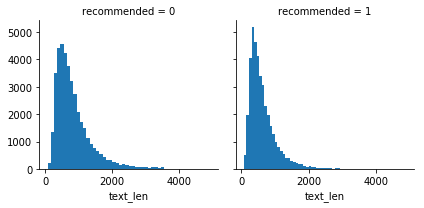

In [16]:
# visualize how words compare with recommended

g = sns.FacetGrid(data=airline, col='recommended')
g.map(plt.hist, 'text_len', bins=50)

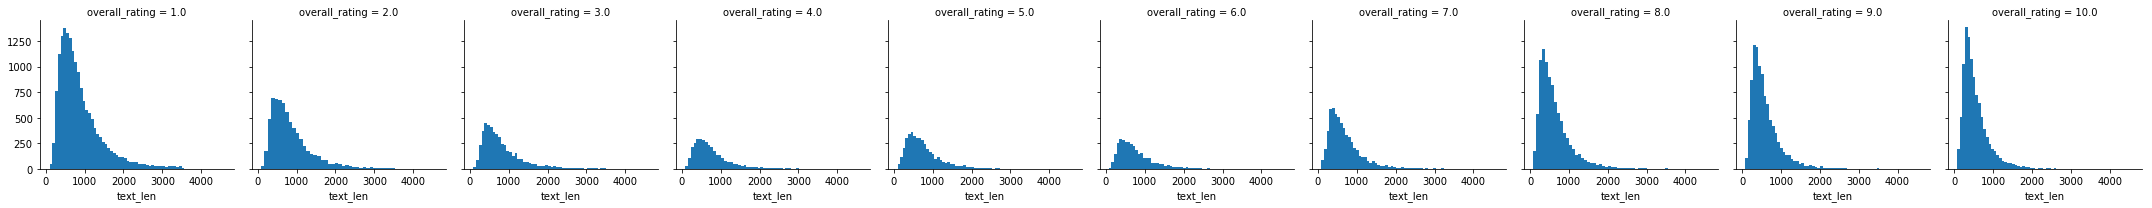

In [17]:
# visualize how words compare with recommended overall_rating

g = sns.FacetGrid(data=airline, col='overall_rating')
g.map(plt.hist, 'text_len', bins=50)

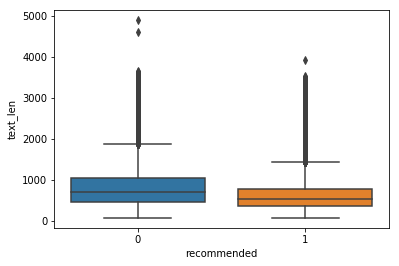

In [18]:
# A further look at both of these
sns.boxplot(x='recommended', y='text_len', data=airline)

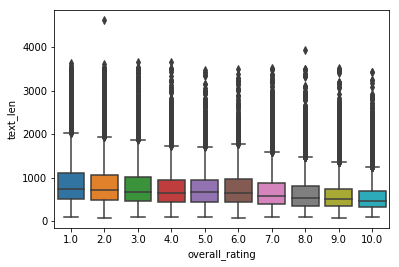

In [19]:
# A further look at both of these
sns.boxplot(x='overall_rating', y='text_len', data=airline)

In [20]:
rating = airline.groupby('overall_rating').mean()
rating.corr()

,cabin_staff_rating,food_beverages_rating,ground_service_rating,inflight_entertainment_rating,recommended,seat_comfort_rating,value_money_rating,wifi_connectivity_rating,date_published,counter,text_len
cabin_staff_rating,1.000000,0.994334,0.997625,0.991635,0.954333,0.997583,0.994633,0.978564,NaN,-0.550785,-0.984574
food_beverages_rating,0.994334,1.000000,0.991280,0.996393,0.941664,0.995810,0.979712,0.992173,NaN,-0.485055,-0.989248
ground_service_rating,0.997625,0.991280,1.000000,0.992820,0.943178,0.997731,0.995471,0.980469,NaN,-0.552365,-0.985184
inflight_entertainment_rating,0.991635,0.996393,0.992820,1.000000,0.919693,0.997601,0.979014,0.996039,NaN,-0.516516,-0.993144
recommended,0.954333,0.941664,0.943178,0.919693,1.000000,0.934366,0.959212,0.900416,NaN,-0.433995,-0.906161
seat_comfort_rating,0.997583,0.995810,0.997731,0.997601,0.934366,1.000000,0.989472,0.988331,NaN,-0.551684,-0.991176
value_money_rating,0.994633,0.979712,0.995471,0.979014,0.959212,0.989472,1.000000,0.959735,NaN,-0.580640,-0.971441
wifi_connectivity_rating,0.978564,0.992173,0.980469,0.996039,0.900416,0.988331,0.959735,1.000000,NaN,-0.458866,-0.989239
date_published,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
counter,-0.550785,-0.485055,-0.552365,-0.516516,-0.433995,-0.551684,-0.580640,-0.458866,NaN,1.000000,0.515037


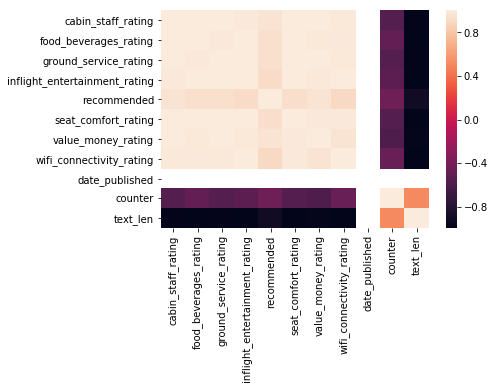

In [21]:
sns.heatmap(data=rating.corr(), annot=False)

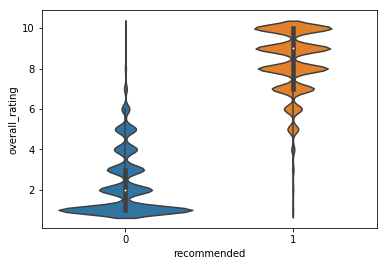

In [22]:
sns.violinplot(airline.recommended, airline.overall_rating)

10, 9, and 8 are almost exclusively recommended while 7, 6, and 5 are sometimes recommended sometimes not recommended.Scores 4 and lower are almost never recommended. 